# PA004: Health Insurance cross sell

##  Planejamento da solução (IOT)

### Database

Information about customers who participate in a survey by answering whether they would be interested in car insurance.

### Input

1. Build a model to order customers most likely to buy vehicle insurance.

### Business Questions

1. Main Insights on the most relevant attributes of customers interested in purchasing auto insurance.




2. What percentage of customers interested in purchasing auto insurance will the sales team be able to contact by making 20,000 calls?





3. If the sales team capacity increases to 40,000 calls, what percentage of customers interested in purchasing auto insurance will the sales team be able to contact?






4. How many calls does the sales team need to make to contact 80% of customers interested in purchasing auto insurance?

### Output

1. Customers interested in car insurance for the sales team to call.

       Customer Id |   interest % 
           01      |     0.99
           02      |     0.97
           03      |     0.90
    
2. Report with business Questions

### Tasks

  1. Model to rank customers by higher interest in car insurance
  
  
  
  

  2. Exploratory Data Analysis Report about the top feature importance





  3. The number of customers interested in car insurance

# 0.0. IMPORTS

In [1]:
import pickle 
import requests
import os


import seaborn                                                     as sns
import pandas                                                      as pd
import psycopg2                                                    as pg
import numpy                                                       as np
import scikitplot                                                  as skplt

from matplotlib                    import pyplot                   as plt


from IPython.core.display          import HTML

# machine learning

from sklearn                       import preprocessing            as pp
from sklearn                       import model_selection          as ms
from sklearn                       import ensemble                 as en
from sklearn                       import neighbors                as nk   
from sklearn                       import linear_model             as lm
from catboost                      import CatBoostClassifier       as cb

# metrics
from scikitplot.metrics            import plot_lift_curve, plot_cumulative_gain
from sklearn.metrics               import roc_auc_score


from flask                        import Flask, request, Response
from dotenv                       import load_dotenv, find_dotenv


import warnings

warnings.filterwarnings("ignore")

## 0.1 Loading Data - Postgres

In [2]:
path = '/home/felipepedrosa/projetos/health_insurance'

In [3]:
load_dotenv(find_dotenv())


True

In [4]:
# credentials
HOST     = os.environ.get( 'DB_HOST' )
PORT     = os.environ.get( 'DB_PORT' ) 
DATABASE = os.environ.get( 'DB_DATABASE' )
USERNAME = os.environ.get( 'DB_USERNAME' ) 
PASSWORD = os.environ.get( 'DB_PASSWORD' )

In [5]:
# conn = pg.connect(user = USERNAME, password = PASSWORD, host = HOST, port = PORT, database = DATABASE)

# query_schema = '''
#     SELECT *
#     FROM pa004.users u  INNER JOIN pa004.vehicle v on (u.id = v.id)
#                         INNER JOIN pa004.insurance i on (u.id = i.id)
# '''

# df_raw = pd.read_sql(query_schema, conn)

# conn.close()

# df_raw.to_pickle(path + '/data/raw/df_raw.pkl')

In [6]:
df1 = pd.read_pickle(path + '/data/raw/df_raw.pkl') 

## 0.2 Helper Functions

In [7]:
def my_settings():
    %matplotlib inline
    
    # plotly settings
    plt.style.use( 'ggplot' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 8
 
    # notebook settings
    display(HTML('<style>.container{width:100% !important;}</style>'))
    np.set_printoptions(suppress=True)
    pd.set_option('display.float_format', '{:.8f}'.format)
    
    # seaborn settings
    sns.set(rc={'figure.figsize':(25,12)})
    sns.set_theme(style = 'darkgrid', font_scale = 1)
my_settings()

In [8]:
def descriptive_stats(df): 
    # Central Tendency - Mean, Median
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

    # dispersion - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
    d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
    d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
    d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

    # concatenar
    m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
    
    return m

In [9]:
def precision_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']

def recall_at_k( data, k=2000 ):
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1 

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']

In [10]:
# Metrics @ k

def metrics_at_k(data, model, x_train, y_train, x_val, y_val, sort=True, verbose=False):
    
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)

    model_df = []
    trained_models = []
    i = 1
    j = len(model)
    for m in model:
        m_name = type(m).__name__
        if verbose:
            print(f"ML - Training model {i}/{j} -> " + m_name + "..." )
        m.fit(x_train, y_train)

        trained_models.append(m)

        # probabilities prediction
        yhat = m.predict_proba(x_val)

        # copy data
        data = x_val.copy()
        data['response'] = y_val.copy()

        # propensity score
        data['score'] = yhat[:, 1].tolist()

        # sort clients by propensity score
        data = data.sort_values('score', ascending=False)

        precision = precision_at_k(data)
        recall = recall_at_k(data)

        i += 1

        df = pd.DataFrame({'Model_Name': m_name, 'Precision@K': precision,
                           'Recall@K': recall}, index=[0]).sort_values('Precision@K', ascending=False)

        model_df.append(df)
        final_model = pd.concat(model_df)
    return final_model.sort_values(by='Precision@K', ascending=False).round(4), trained_models

In [11]:
# cross validation
def cross_validation( data, model, x_train, y_train, k, sort=True, verbose=False ):
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)

    kfold = ms.StratifiedKFold(n_splits=k, shuffle=True, random_state=17)
    precision_list = []
    recall_list = []
    model_df = []
    j = 1
    l = len(model)

    for m in model:
        i = 1
        m_name = type(m).__name__
        if verbose:
            print(f"CV - Folding model {j}/{l} -> " + m_name + "..." )
        for train_cv, val_cv in kfold.split(x_train, y_train):
            if verbose:
                print(f'Fold Number {i}/{k}')
            x_train_fold = x_train.iloc[train_cv]
            y_train_fold = y_train.iloc[train_cv]
            x_val_fold = x_train.iloc[val_cv]
            y_val_fold = y_train.iloc[val_cv]

            model_fit = m.fit(x_train_fold, y_train_fold)
            yhat = m.predict_proba(x_val_fold)

            data = x_val_fold.copy()
            data['response'] = y_val_fold.copy()
            data['score'] = yhat[:, 1].tolist()
            data = data.sort_values('score', ascending=False)

            precision = precision_at_k(data)
            precision_list.append(precision)

            recall = recall_at_k(data)
            recall_list.append(recall)

            i += 1

        df = pd.DataFrame({'Model_Name': m_name,
                           'Precision@K Mean': np.mean(precision_list).round(4),
                           'Precision@K STD': np.std(precision_list).round(4),
                           'Recall@K Mean': np.mean(recall_list).round(4),
                           'Recall@K STD': np.std(recall_list).round(4)}, index=[0])
        j += 1
        model_df.append(df)
        final_model = pd.concat(model_df)

    return final_model

In [12]:
 # Plot cumulative Gain Curve & Lift Curve
def plot_cgc_lc(model, x_train, y_train, x_val, sort=True, fit=True, verbose=False ):
    if sort:
        model = sorted(model, key=lambda x: type(x).__name__)
    i = 1
    j = len(model)
    for m in model:
        m_name = type(m).__name__
        if verbose: 
            print(f"Calulating curve for model {i}/{j} -> " + m_name + "..." )
        if fit:
            if verbose:
                print(f"Training model ... ")
            m.fit(x_train, y_train)
                
        # probabilities prediction
        yhat_model = m.predict_proba(x_val)
        fig, axs = plt.subplots(ncols=2, figsize=(20,6))
        plot_cumulative_gain(y_val, yhat_model, ax=axs[0], text_fontsize='small', title='Cumulative Gain Curve - ' + m_name) # Cumulative Gain Curve
        plot_lift_curve(y_val, yhat_model, ax=axs[1], text_fontsize='small', title='Lift Curve - ' + m_name); # Lift curve
        i += 1

# 1.0. Data Description


    id:                  Unique ID for the customer
    gender:              Gender of the customer
    age:                 Age of the customer
    driving_license:     0 - Customer does not have DL / 1 - Customer already has DL
    region_code:         Unique code for the region of the customer
    previously_insured:  1 - Customer already has Vehicle Insurance / 0 - Customer doesn't have Vehicle Insurance
    vehicle_age:         age of the Vehicle
    vehicle_damage:      1 - Customer got his/her vehicle damaged in the past / 0 - Customer didn't get his/her vehicle damaged in the past.
    annual_premium:      The amount customer needs to pay as premium in the year
    policy_sales_hannel: Anonymized Code for the channel of outreaching to the customer id. Different Agents, Over Mail, Over Phone, In Person, etc.
    vintage:             Number of Days, Customer has been associated with the company
    response:            1 - Customer is interested / 0 - Customer is not interested}

## 1.1. Organize columns

In [13]:
 # removing duplicated columns
df1 = df1.loc[:, ~ df1.columns.duplicated()]

## 1.2. Data Dimensions

In [14]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 381109
Number of Cols: 12


## 1.3. Data Types

In [15]:
df1.dtypes 

id                        int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
previously_insured        int64
annual_premium          float64
vintage                   int64
response                  int64
dtype: object

## 1.4. Check NA

In [16]:
df1.isna().sum() 

id                      0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
previously_insured      0
annual_premium          0
vintage                 0
response                0
dtype: int64

## 1.5. Data Descriptive

In [17]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64','datetime64[ns]'])

### 1.5.1 Numerical Attributes


In [18]:
descriptive_stats(num_attributes)

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1.00000000,381109.00000000,381108.00000000,190555.00000000,190555.00000000,110016.69186992,-0.00000000,-1.20000000
1,age,20.00000000,85.00000000,65.00000000,38.82258357,36.00000000,15.51159067,0.67253900,-0.56565507
2,region_code,0.00000000,52.00000000,52.00000000,26.38880740,28.00000000,13.22987067,-0.11526641,-0.86785712
3,policy_sales_channel,1.00000000,163.00000000,162.00000000,112.03429465,133.00000000,54.20392366,-0.90000812,-0.97081018
4,driving_license,0.00000000,1.00000000,1.00000000,0.99786938,1.00000000,0.04610948,-21.59518153,464.35430215
5,previously_insured,0.00000000,1.00000000,1.00000000,0.45821012,0.00000000,0.49825055,0.16774712,-1.97187125
6,annual_premium,2630.00000000,540165.00000000,537535.00000000,30564.38958146,31669.00000000,17213.13247397,1.76608721,34.00456870
7,vintage,10.00000000,299.00000000,289.00000000,154.34739668,154.00000000,83.67119385,0.00302952,-1.20068804
8,response,0.00000000,1.00000000,1.00000000,0.12256336,0.00000000,0.32793533,2.30190580,3.29878763


# 2.0. Feature Engineering


In [19]:
df2 = df1.copy()

In [20]:
df2.head()

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.00000000,152.00000000,1,< 1 Year,Yes,0,23367.00000000,249,0
1,13,Female,41,15.00000000,14.00000000,1,1-2 Year,No,1,31409.00000000,221,0
2,18,Female,25,35.00000000,152.00000000,1,< 1 Year,No,1,46622.00000000,299,0
3,31,Female,26,8.00000000,160.00000000,1,< 1 Year,No,0,2630.00000000,136,0
4,39,Male,45,8.00000000,124.00000000,1,1-2 Year,Yes,0,42297.00000000,264,0


In [21]:
# vehicule age
df2['vehicle_age'] =  df2['vehicle_age'].apply( lambda x: 2 if x == '> 2 Years' else 1 if x == '1-2 Year' else 0 )

# vehiculde damage
df2['vehicle_damage'] = df2['vehicle_damage'].map({'Yes' : 1 , 'No' : 0})


In [22]:
# df2['potential_to_hire'] =  df2['gender'].map({'Male':0, 'Female':1}) + \
#                             df2['vehicle_age'].map({'< 1 Year':3, '1-2 Year':2, '> 2 Years':0}) + \
#                             df2['vehicle_damage'].map({'Yes':1, 'No':0}) + \
#                             df2['previously_insured'] + \
#                             df2['age'].apply(age_weight_select) # see in helper functions

# if add_response:
#     df2['potential_to_hire'] =  df2['potential_to_hire'] + \
#                                 df2['response'] # malum discordiae

# 3.0. Data Filtering


In [23]:
df3 = df2.copy()

# 4.0. Exploratoria Data Analysis (EDA)


In [24]:
df4 = df3.copy()

## 4.1. Univariate Analysis


In [25]:
df4.columns

Index(['id', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

<AxesSubplot:xlabel='response', ylabel='age'>

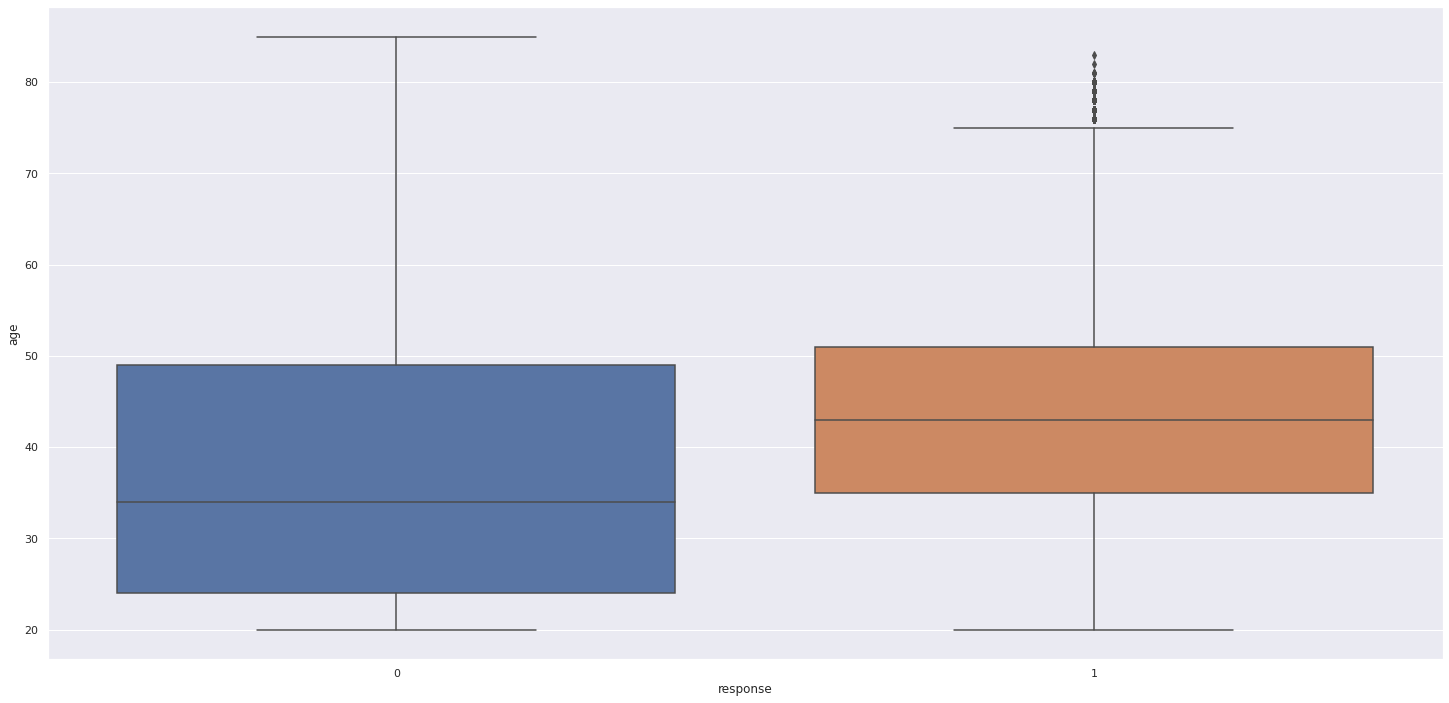

In [26]:
# age
sns.boxplot(x ='response' , y = 'age' , data=df4)

<AxesSubplot:xlabel='age', ylabel='Count'>

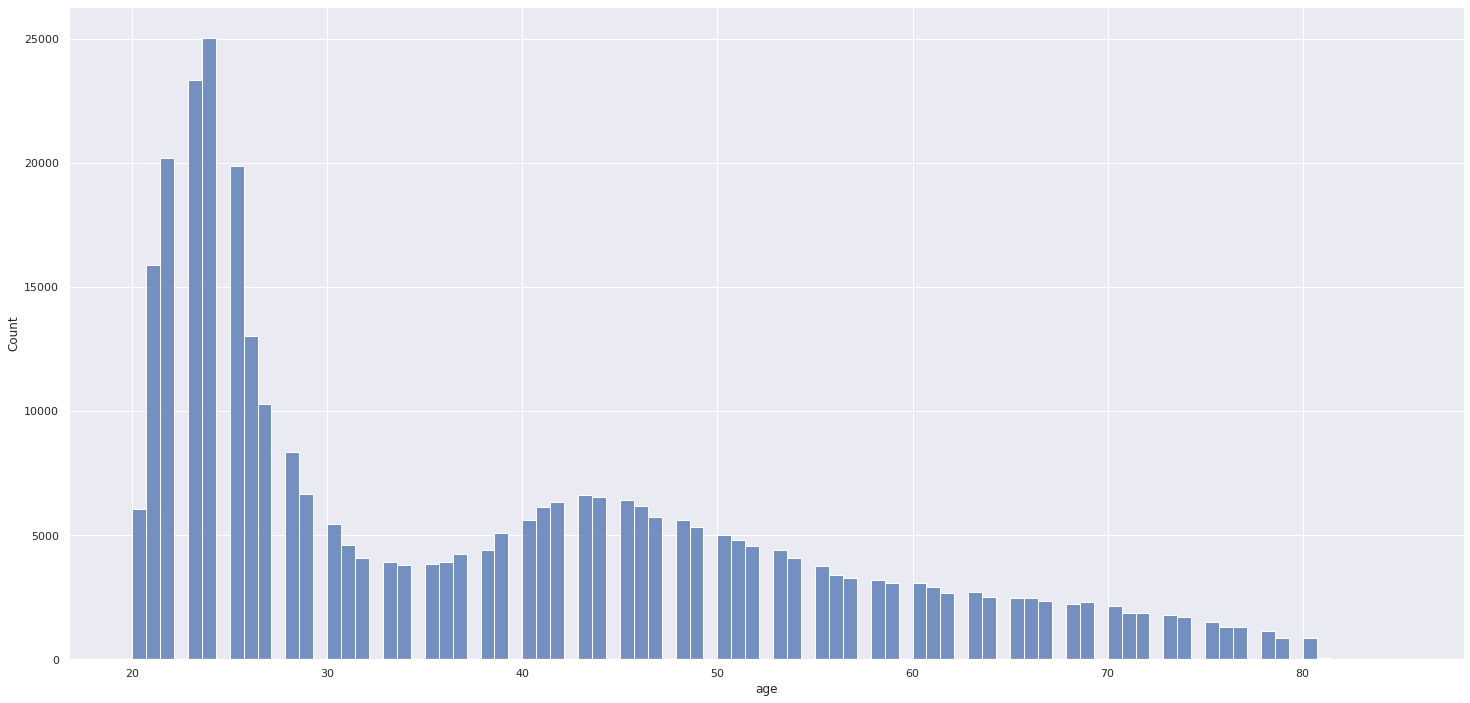

In [27]:
aux00 = df4.loc[df4['response'] == 0,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='age', ylabel='Count'>

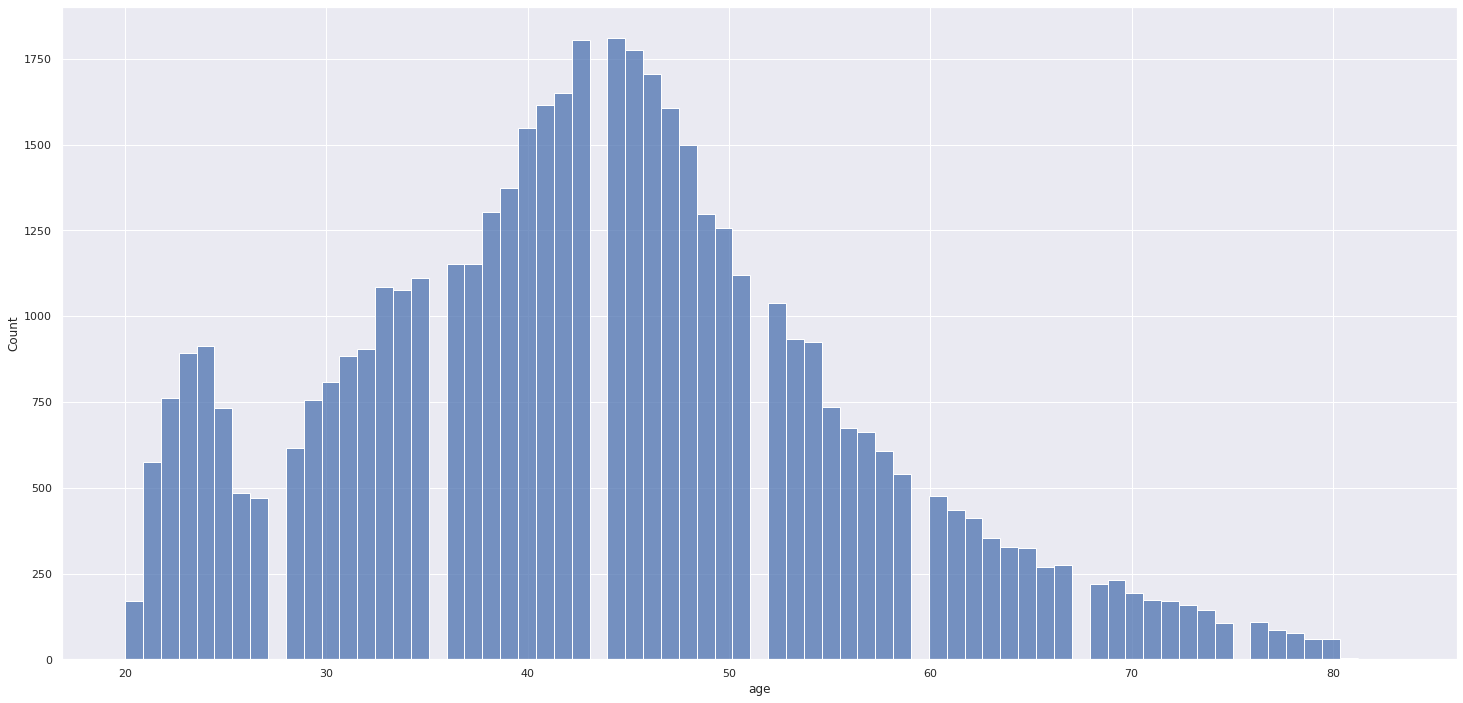

In [28]:
aux00 = df4.loc[df4['response'] == 1,'age']
sns.histplot(aux00)

<AxesSubplot:xlabel='response', ylabel='annual_premium'>

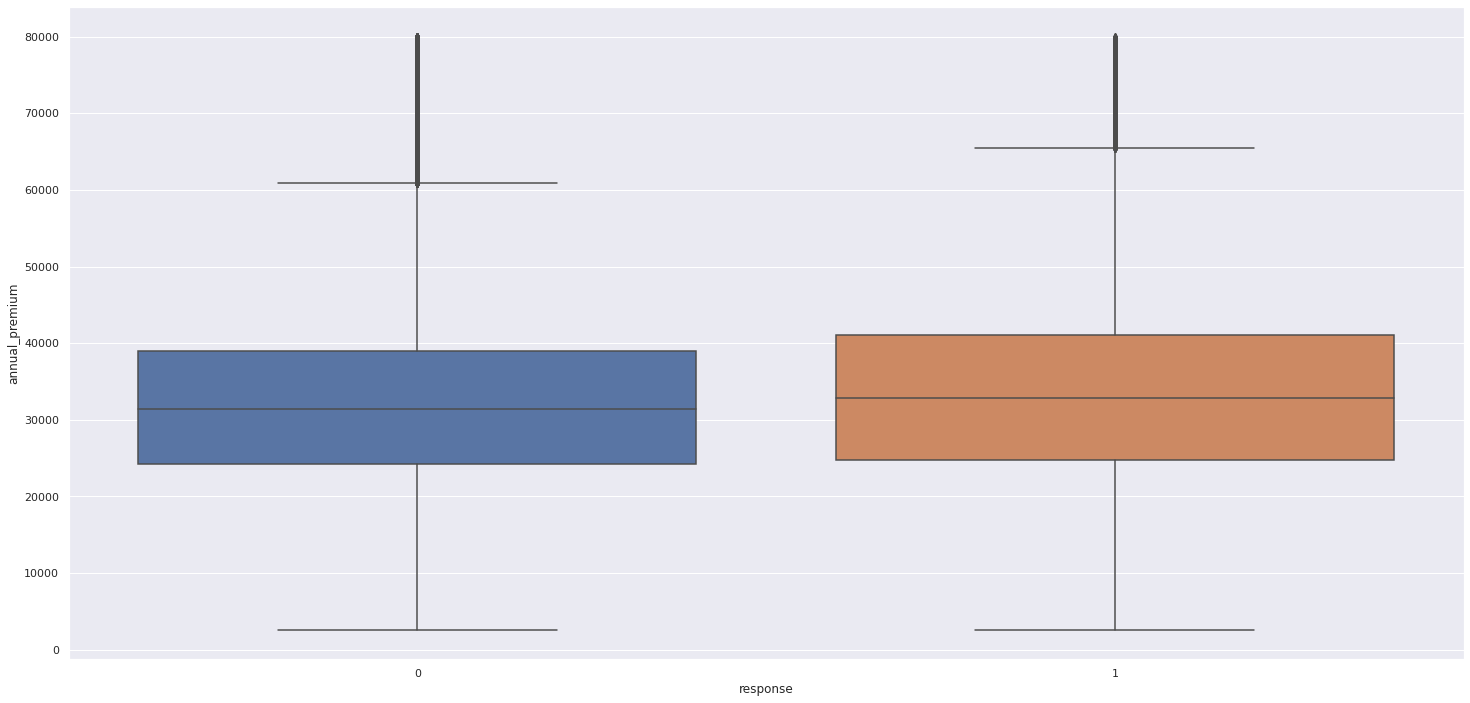

In [29]:
# annual_premium

aux = df4[df4['annual_premium'] < 80000]
sns.boxplot(x ='response' , y = 'annual_premium' , data=aux)


<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

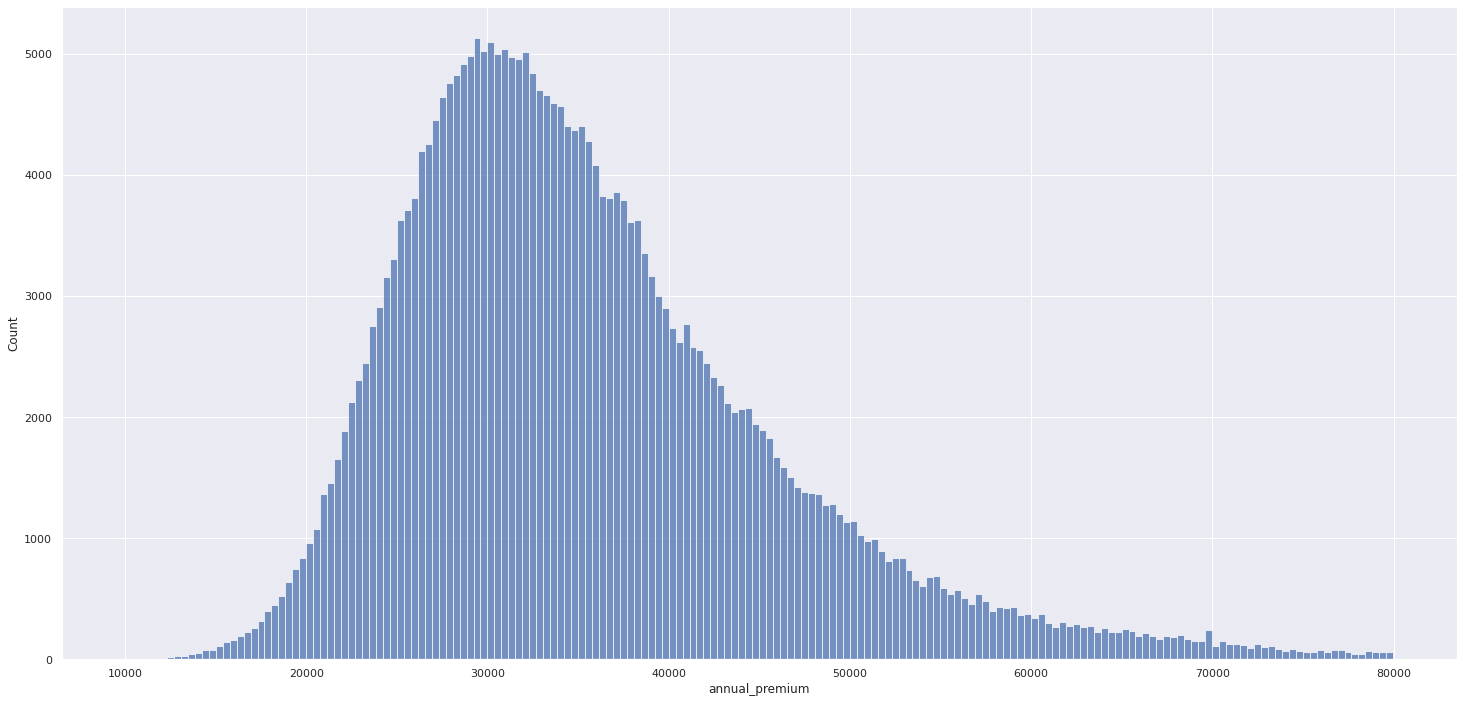

In [30]:
aux = df4[(df4['annual_premium']  > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 0,'annual_premium']
sns.histplot(aux00)

<AxesSubplot:xlabel='annual_premium', ylabel='Count'>

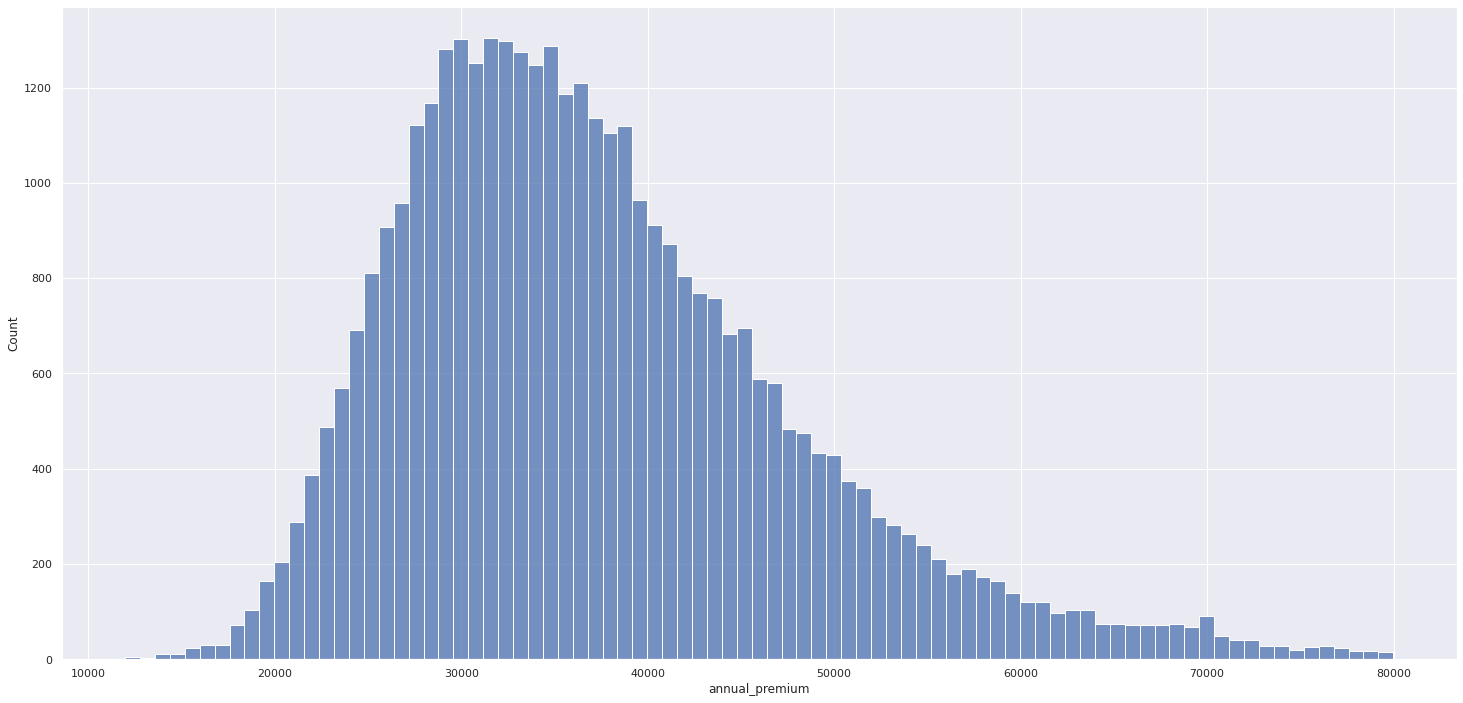

In [31]:
aux = df4[(df4['annual_premium'] > 10000) & (df4['annual_premium'] < 80000)]
aux00 = aux.loc[df4['response'] == 1,'annual_premium']
sns.histplot(aux00)

In [32]:
# driving_license

aux = df4[['driving_license','response']].groupby('response').sum().reset_index()
aux.head()   
aux['driving_license_perc'] = aux['driving_license'] / aux['driving_license'].sum()
# sns.barplot(x ='response' , y = 'driving_license' , data=aux)


In [33]:
aux

,response,driving_license,driving_license_perc
0,0,333628,0.87728276
1,1,46669,0.12271724


<AxesSubplot:xlabel='region_code', ylabel='id'>

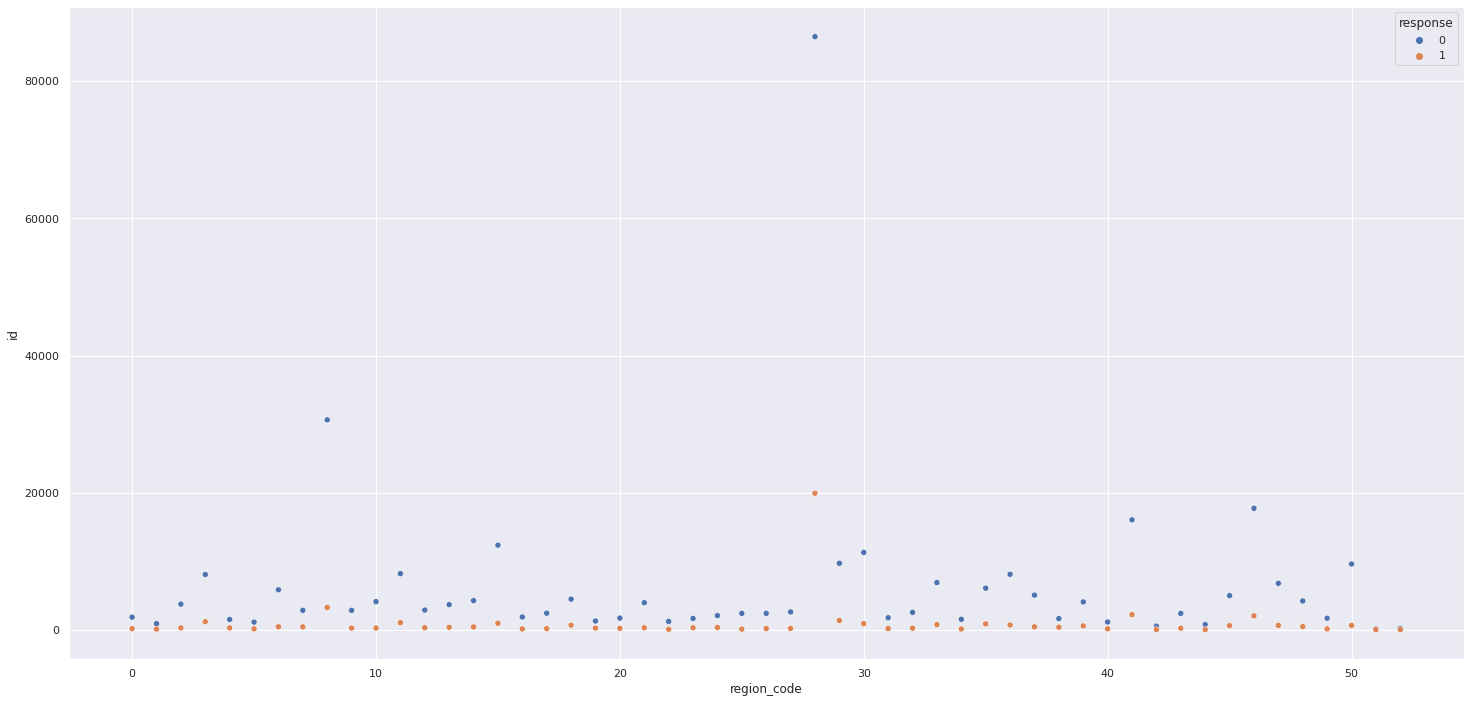

In [34]:
# region_code

aux0 = df4[['id','region_code','response']].groupby(['region_code','response']).count().reset_index()


sns.scatterplot(x= 'region_code' , y='id' , hue='response' , data=aux0)

In [35]:
# previously_insured

pd.crosstab(df4['previously_insured'],df4['response'] ).apply(lambda x: x / x.sum() , axis =1)

response,0,1
previously_insured,,
0,0.77454584,0.22545416
1,0.99909522,0.00090478


In [36]:
# vehicle_age

df4[['id','vehicle_age', 'response']].groupby( ['vehicle_age', 'response'] ).count().reset_index() 

,vehicle_age,response,id
0,0,0,157584
1,0,1,7202
2,1,0,165510
3,1,1,34806
4,2,0,11305
5,2,1,4702


<AxesSubplot:xlabel='response', ylabel='policy_sales_channel'>

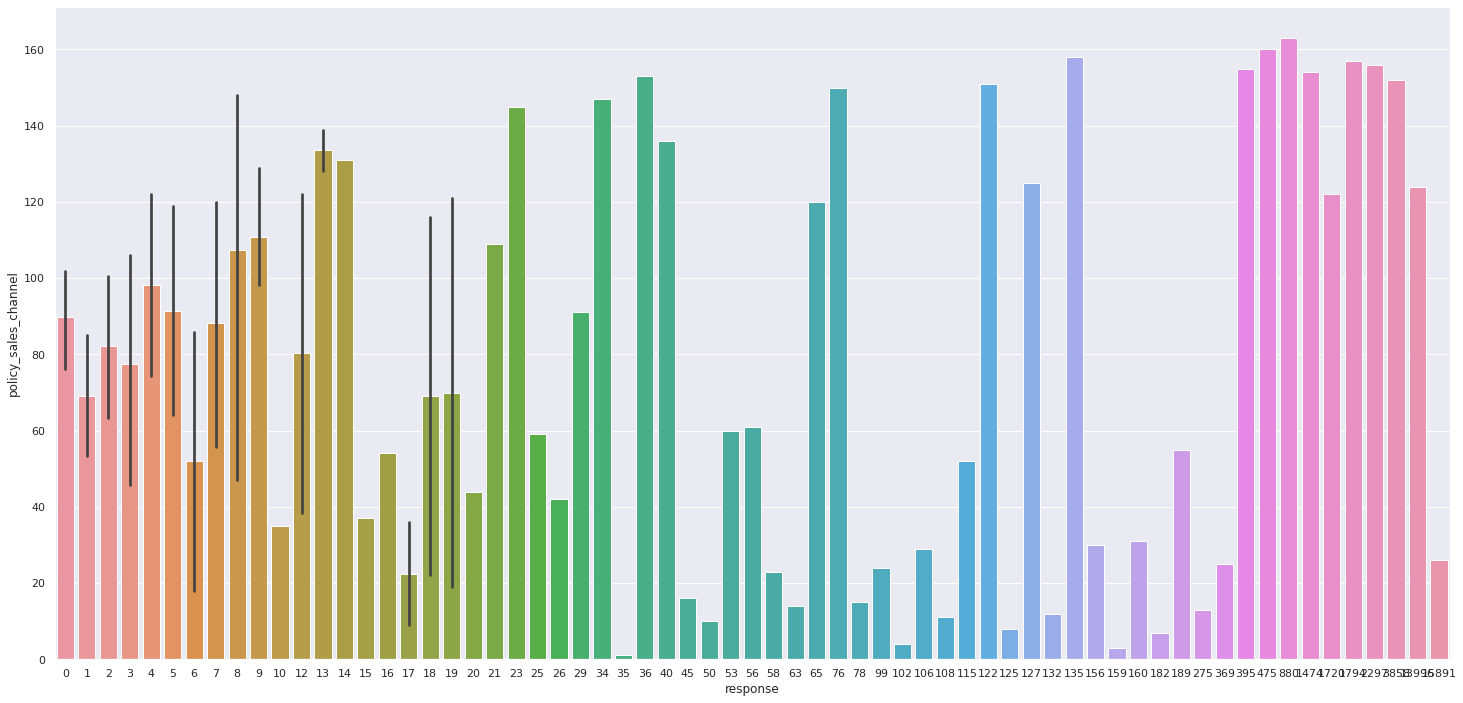

In [37]:
# policy_sales_channel

aux0 = df4[['policy_sales_channel','response']].groupby('policy_sales_channel').sum().reset_index()
sns.barplot(x ='response' , y= 'policy_sales_channel' , data=aux0) 

<AxesSubplot:xlabel='response', ylabel='vintage'>

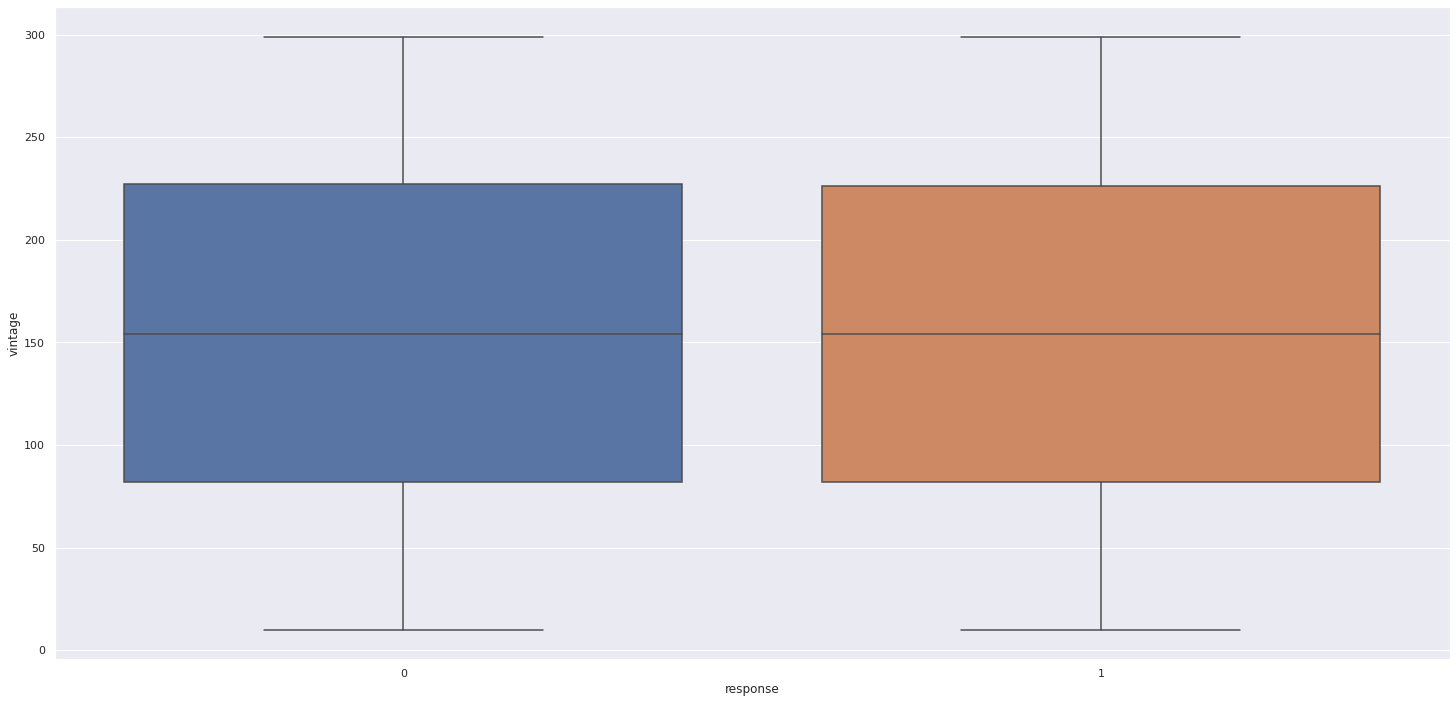

In [38]:
# vintage


sns.boxplot(x ='response' , y = 'vintage' , data=df4)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

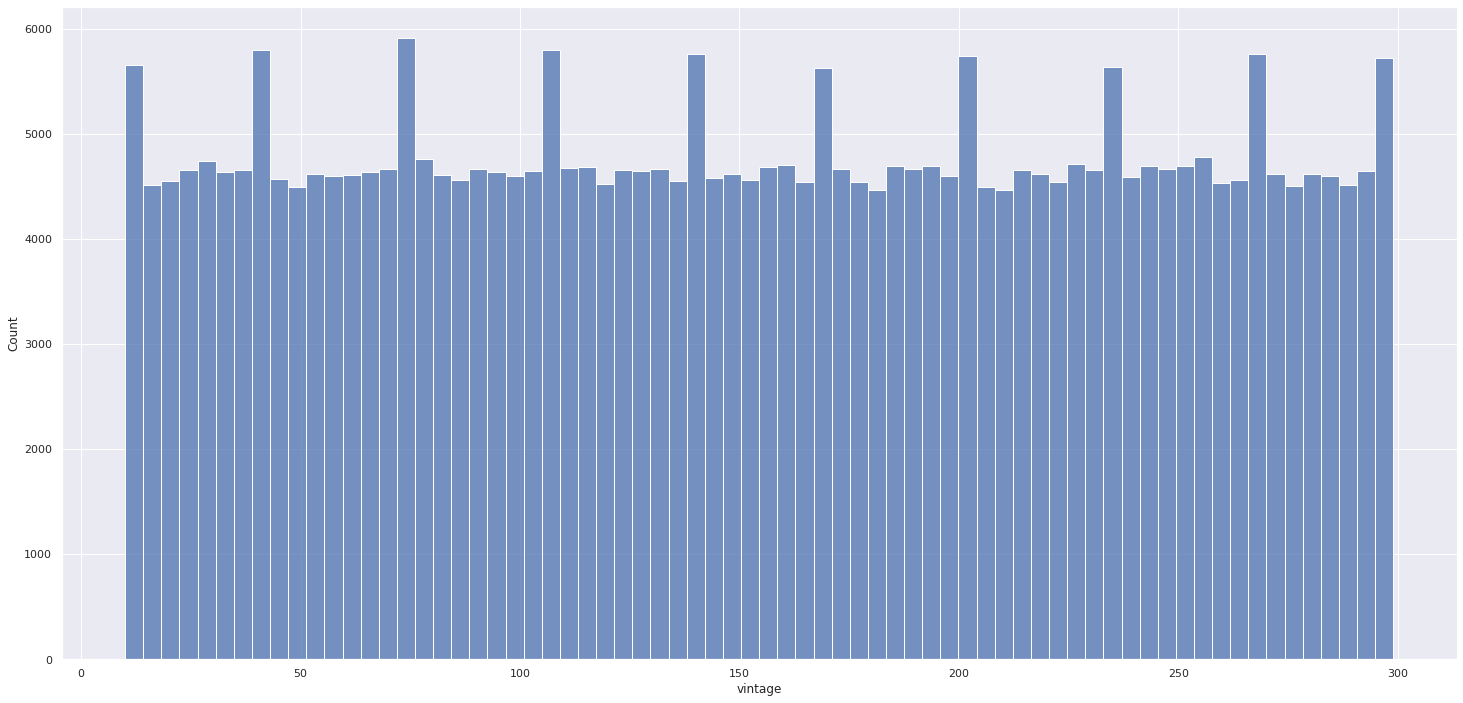

In [39]:
aux00 = df4.loc[df4['response'] == 0,'vintage']
sns.histplot(aux00)

<AxesSubplot:xlabel='vintage', ylabel='Count'>

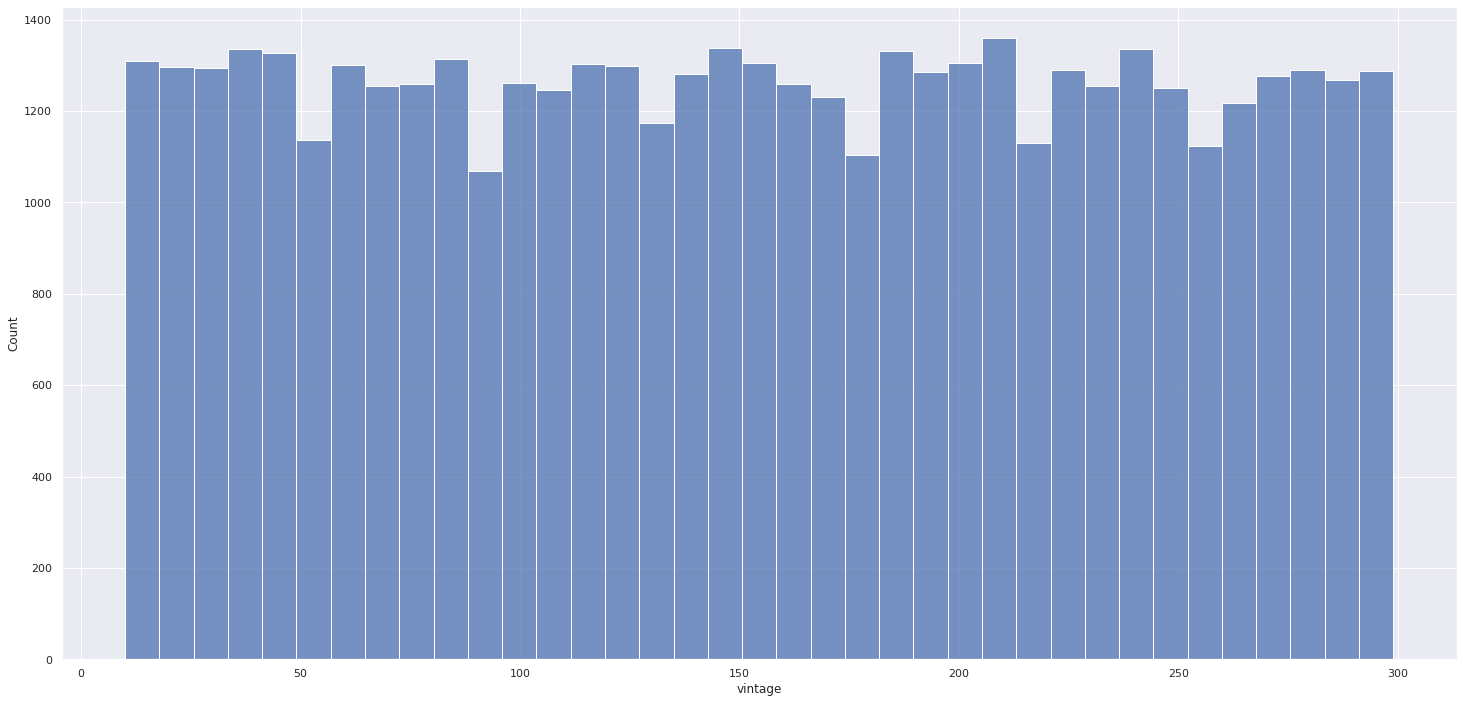

In [40]:
aux00 = df4.loc[df4['response'] == 1,'vintage']
sns.histplot(aux00)

## 4.2. Bivariate Analysis


# 5.0. Data Preparation


In [41]:
df5 = df4.copy()

In [42]:
x = df5.drop('response' , axis=1)
y = df5['response'].copy()

# train TEST split
x_train, x_test, y_train, y_test = ms.train_test_split(x, y, test_size=0.20, random_state=17, shuffle=True)

# train VALID split
x_train, x_val, y_train, y_val = ms.train_test_split(x_train, y_train, test_size=0.20, random_state=17, shuffle=True)



df51 = pd.concat([x_train,y_train], axis=1)

## 5.1. Standardization


In [43]:
ss =pp.StandardScaler()

# annual_premium
df51['annual_premium'] = ss.fit_transform(df51[['annual_premium']].values)
pickle.dump(ss, open('../src/features/annual_premium_scaler.pkl' , 'wb'))

## 5.2. Rescaling


In [44]:
mms_age = pp.MinMaxScaler()
mms_vintage = pp.MinMaxScaler()

# Age
df51['age'] = mms_age.fit_transform(df51[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl' , 'wb'))

# vintage
df51['vintage'] = mms_vintage.fit_transform(df51[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl' , 'wb'))

## 5.3. Encoder


In [45]:
# gender - Target encoding
target_encode_gender = df51.groupby('gender')['response'].mean()
df51.loc[: , 'gender'] = df51['gender'].map(target_encode_gender)
pickle.dump(target_encode_gender, open('../src/features/target_encode_gender_scaler.pkl' , 'wb'))

# region_code - Target Encoding
target_encode_region_code = df51.groupby('region_code')['response'].mean()
df51.loc[: , 'region_code'] = df51['region_code'].map(target_encode_region_code)
pickle.dump(target_encode_region_code, open('../src/features/target_encode_region_code_scaler.pkl' , 'wb'))

# vehicle_age - One Hot Encoding
#df51 = pd.get_dummies(df51 , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel - Frequency Encoding
fe_policy_sales_channel = df51.groupby('policy_sales_channel').size() / len(df51)
df51.loc[: , 'policy_sales_channel'] = df5['policy_sales_channel'].map(fe_policy_sales_channel)
pickle.dump(fe_policy_sales_channel, open('../src/features/fe_policy_sales_channel_scaler.pkl' , 'wb'))

# fillna
df51 = df51.fillna(0)

## 5.4. Validation Preparation

In [46]:
# gender
x_val.loc[: , 'gender'] = x_val.loc[: , 'gender'].map(target_encode_region_code)

# Age
x_val.loc[: , 'gender'] = mms_age.fit_transform(x_val[['age']].values)

# vintage
x_val['vintage'] = mms_vintage.fit_transform(x_val[['vintage']].values)

# region_code 
x_val.loc[: , 'region_code'] = x_val.loc[: , 'region_code'].map(target_encode_region_code)

# annual_premium
x_val['annual_premium'] = ss.fit_transform(x_val[['annual_premium']].values)

# vehicle_age 
#x_val = pd.get_dummies(x_val , prefix= 'vehicle_age', columns=['vehicle_age'])

# policy_sales_channel 
x_val.loc[: , 'policy_sales_channel'] = x_val['policy_sales_channel'].map(fe_policy_sales_channel)

# fillna
x_val = x_val.fillna(0)


# 6.0. Feature Selection


In [47]:
df6 = df51.copy()

## 6.1. Feature Importancia

In [48]:
# model definition
forest = en.ExtraTreesClassifier(n_estimators=250, random_state=0, n_jobs=-1)

# data preparation
x_train_n = df6.drop(['id', 'response'], axis= 1)
y_train_n = y_train.values
forest.fit(x_train_n , y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking: 
                feature  importances
0               vintage   0.27571912
0        annual_premium   0.24262547
0                   age   0.16186502
0           region_code   0.10631590
0        vehicle_damage   0.07724667
0  policy_sales_channel   0.06097002
0    previously_insured   0.05220850
0           vehicle_age   0.01677814
0                gender   0.00576995
0       driving_license   0.00050120


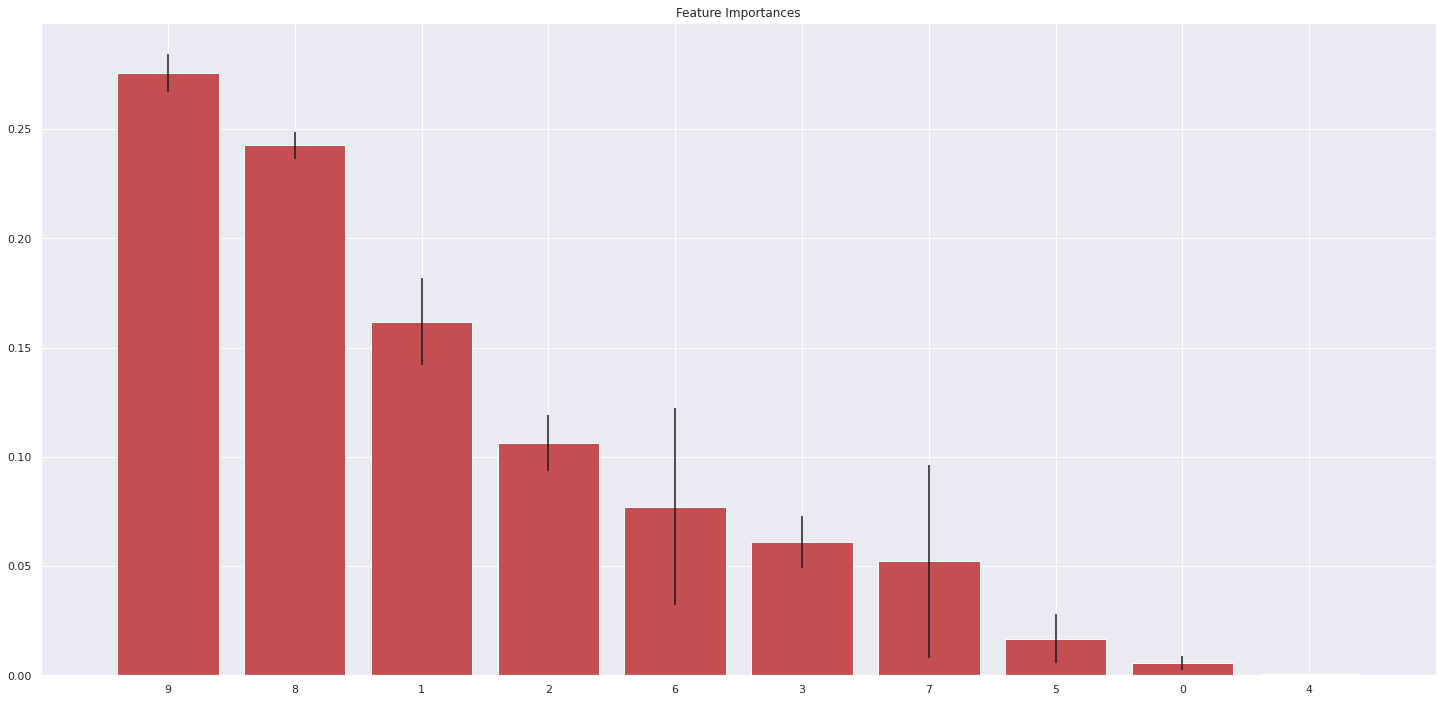

In [49]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_] , axis= 0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print('Feature ranking: ')
df =pd.DataFrame()
for i, j in zip(x_train_n, forest.feature_importances_):
    aux = pd.DataFrame({'feature': i, 'importances': j}, index=[0])
    df = pd.concat([df,aux], axis = 0)
    
print(df.sort_values('importances', ascending= False))
    
# Plot tge umpurity-based feature importances of the forest
plt.figure()
plt.title("Feature Importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color= 'r', yerr= std[indices], align= 'center')
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()


# 7.0. Machine Learning Modelling


In [50]:
df7 = df6.copy()

In [51]:
cols_selected = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

df7 = df7[cols_selected]
x_train = df51[cols_selected]
x_validation = x_val[cols_selected]


In [52]:
models=[nk.KNeighborsClassifier(n_neighbors = 500),
       lm.LogisticRegression(random_state = 42),
       #en.RandomForestClassifier( n_estimators=1000,max_depth = 20, n_jobs=-1, random_state=42 ),
       cb( random_state=42, verbose=False )]

In [53]:
%time
ml_results, trained_models = metrics_at_k(df7, models, x_train, y_train, x_validation, y_val, verbose=True )
%time

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.29 µs
ML - Training model 1/3 -> CatBoostClassifier...
ML - Training model 2/3 -> KNeighborsClassifier...
ML - Training model 3/3 -> LogisticRegression...
CPU times: user 22 µs, sys: 2 µs, total: 24 µs
Wall time: 7.39 µs


In [54]:
ml_results

,Model_Name,Precision@K,Recall@K
0,CatBoostClassifier,0.30680000,0.08210000
0,KNeighborsClassifier,0.15440000,0.04130000
0,LogisticRegression,0.09100000,0.02430000


## Cross-Validation

In [55]:
models_cv =[nk.KNeighborsClassifier(n_neighbors = 500),
            lm.LogisticRegression(random_state = 42),
            #en.RandomForestClassifier( n_estimators=1000,max_depth = 20, n_jobs=-1, random_state=42 ),
            cb( random_state=42, verbose=False )]

In [56]:
x = cb( random_state=42, verbose=False )

In [57]:
x

In [58]:
cv_results = cross_validation(df7, models_cv, x_train, y_train, 5 )  

In [59]:
ml_cv_results = pd.merge(ml_results, cv_results, on = 'Model_Name', how='left')
ml_cv_results = ml_cv_results.fillna( 0 )

In [60]:
ml_cv_results

,Model_Name,Precision@K,Recall@K,Precision@K Mean,Precision@K STD,Recall@K Mean,Recall@K STD
0,CatBoostClassifier,0.30680000,0.08210000,0.40430000,0.00430000,0.13580000,0.00140000
1,KNeighborsClassifier,0.15440000,0.04130000,0.38580000,0.01970000,0.12960000,0.00660000
2,LogisticRegression,0.09100000,0.02430000,0.35050000,0.05250000,0.11770000,0.01760000


In [61]:
cat_model = models_cv[2]

In [62]:
cat_model

## Ploting Curves

In [63]:
models_cv_plot =[#nk.KNeighborsClassifier(n_neighbors = 500),
           # lm.LogisticRegression(random_state = 42),
            #en.RandomForestClassifier( n_estimators=1000,max_depth = 20, n_jobs=-1, random_state=42 ),
            cb( random_state=42, verbose=False )]

Calulating curve for model 1/1 -> CatBoostClassifier...
Training model ... 


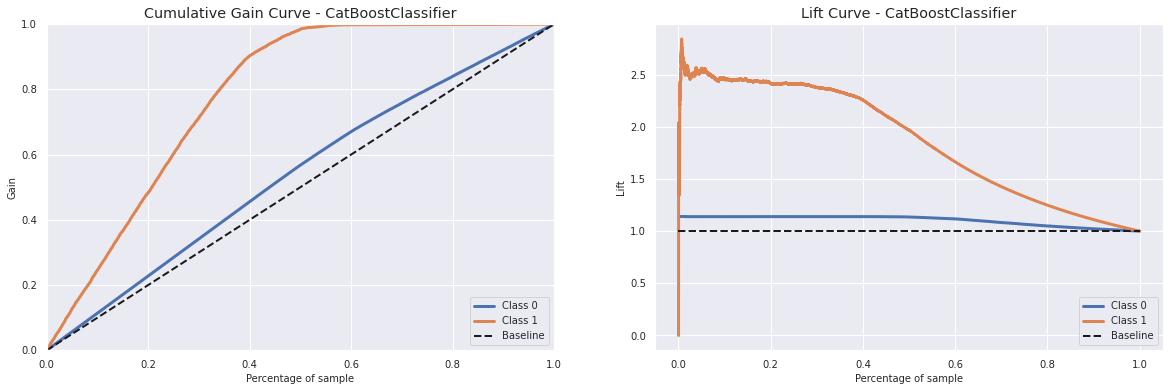

In [64]:
plot_cgc_lc(models_cv_plot, x_train, y_train, x_val, verbose=True) 

# 9.0. Deploy to Production


In [65]:
# save trained model
pickle.dump(cat_model , open('/home/felipepedrosa/projetos/health_insurance/src/models/cat_model.pkl' , 'wb'))

## 9.1. API Tester


In [66]:
# loading test dataset

df_test = x_val
df_test['response'] = y_val

In [67]:
df_test = df_test.sample(10)

In [84]:
df_test

,id,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
256044,140500,0.03076923,22,0.07207322,0.35462406,1,0,0,1,0.08597695,0.05882353,0
252521,112374,0.06153846,24,0.08818959,0.01013083,1,0,0,1,0.26303076,0.14878893,0
370644,297231,0.35384615,43,0.18644966,0.19318270,1,1,1,0,0.85155835,0.18685121,0
41671,332522,0.29230769,39,0.10485344,0.01764183,1,2,1,0,-1.62900234,0.98961938,0
50369,20454,0.07692308,25,0.12516801,0.35462406,1,0,0,1,-0.31873415,0.68166090,0
121063,204607,0.13846154,29,0.09453471,0.35462406,1,0,0,1,0.09308942,0.06920415,0
370937,299426,0.32307692,41,0.18644966,0.01764183,1,1,1,0,-1.62900234,0.56401384,0
148043,40533,0.16923077,31,0.07032993,0.35462406,1,0,0,1,0.02324731,0.36332180,0
289906,30004,0.33846154,42,0.18644966,0.20883198,1,2,1,0,0.03927951,0.76816609,1
152622,76701,0.40000000,46,0.18644966,0.19318270,1,2,1,0,1.44014423,0.96885813,0


In [85]:
df_test.to_csv('propensy_score_test.csv')

In [70]:
# convert dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [71]:
data

'[{"id": 140500, "gender": 0.03076923076923077, "age": 22, "region_code": 0.07207321723655777, "policy_sales_channel": 0.3546240606127695, "driving_license": 1, "vehicle_age": 0, "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 0.08597694721157792, "vintage": 0.058823529411764705, "response": 0}, {"id": 112374, "gender": 0.06153846153846154, "age": 24, "region_code": 0.08818958818958819, "policy_sales_channel": 0.010130827480740769, "driving_license": 1, "vehicle_age": 0, "vehicle_damage": 0, "previously_insured": 1, "annual_premium": 0.2630307627246692, "vintage": 0.14878892733564014, "response": 0}, {"id": 297231, "gender": 0.3538461538461539, "age": 43, "region_code": 0.18644966492377937, "policy_sales_channel": 0.19318270338527893, "driving_license": 1, "vehicle_age": 1, "vehicle_damage": 1, "previously_insured": 0, "annual_premium": 0.8515583450772066, "vintage": 0.18685121107266436, "response": 0}, {"id": 332522, "gender": 0.2923076923076924, "age": 39, "region_cod

In [82]:
# API Call

url = 'https://health-insurance-model-score.herokuapp.com/predict'
header = {'Content-type': 'application/json'}     

r = requests.post(url , data = data , headers = header)
print('Status code {}'.format(r.status_code))

Status code 200


In [83]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values('score', ascending = False).head()

,id,gender,age,driving_license,region_code,previously_insured,vehicle_age,vehicle_damage,annual_premium,policy_sales_channel,vintage,response,score
9,76701,None,0.40000000,0.18644966,None,1,0,0,-1.77779178,1.44014423,-0.03124963,0,0.00000067
8,30004,None,0.33846154,0.18644966,None,1,0,0,-1.77779178,0.03927951,-0.03194406,1,0.00000058
3,332522,None,0.29230769,0.10485344,None,1,0,0,-1.77779178,-1.62900234,-0.03117779,0,0.00000052
2,297231,None,0.35384615,0.18644966,None,1,0,0,-1.77779178,0.85155835,-0.03395553,0,0.00000043
0,140500,None,0.03076923,0.07207322,None,1,0,0,-1.77773365,0.08597695,-0.03439853,0,0.00000036
